In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
# If you prefer UMAP over t-SNE, ensure you have 'umap-learn' installed:
# !pip install umap-learn

# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)   

# Load the dataset
# Red wine data
url_red_wine = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
red_wine = pd.read_csv(url_red_wine, sep=';')
red_wine['type'] = 'red'

# White wine data
url_white_wine = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
white_wine = pd.read_csv(url_white_wine, sep=';')
white_wine['type'] = 'white'

# Combine datasets
wine_data = pd.concat([red_wine, white_wine], ignore_index=True)

# Display the first few rows of the combined dataset
print("First 5 rows of the combined dataset:")
print(wine_data.head())

# Get a concise summary of the DataFrame
print("\nDataFrame Info:")
wine_data.info()

# Check for missing values
print("\nMissing values before handling:")
print(wine_data.isnull().sum())

First 5 rows of the combined dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  alcohol  quality type
0            7.4              0.70         0.00             1.9      0.076                 11.0                  34.0   0.9978  3.51       0.56      9.4        5  red
1            7.8              0.88         0.00             2.6      0.098                 25.0                  67.0   0.9968  3.20       0.68      9.8        5  red
2            7.8              0.76         0.04             2.3      0.092                 15.0                  54.0   0.9970  3.26       0.65      9.8        5  red
3           11.2              0.28         0.56             1.9      0.075                 17.0                  60.0   0.9980  3.16       0.58      9.8        6  red
4            7.4              0.70         0.00             1.9      0.076                 11.0                  34.0   0.9978 

In [ ]:
X = wine_data.drop(['quality', 'type'], axis=1)
y = wine_data['quality']
wine_type = wine_data['type'] # Keeping track of wine type for visualization

print("\nDescriptive statistics of the features before outlier handling and scaling:")
print(X.describe())

# --- Outlier Detection and Handling ---
# Function to cap outliers
def cap_outliers_iqr(df):
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']: 
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

print("\nApplying outlier capping...")
X_cleaned = cap_outliers_iqr(X.copy()) # Apply to a copy to keep original X for comparison if needed

print("\nDescriptive statistics of the features after outlier capping:")
print(X_cleaned.describe())

# --- Feature Scaling ---
print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cleaned)

# Convert the scaled array back to a DataFrame for easier handling and inspection
X_scaled = pd.DataFrame(X_scaled, columns=X_cleaned.columns)

print("\nFirst 5 rows of scaled features:")
print(X_scaled.head())
print("\nDescriptive statistics of scaled features (should be close to mean 0, std dev 1):")
print(X_scaled.describe())


Descriptive statistics of the features before outlier handling and scaling:
       fixed acidity  volatile acidity  citric acid  residual sugar    chlorides  free sulfur dioxide  total sulfur dioxide      density           pH    sulphates      alcohol
count    6497.000000       6497.000000  6497.000000     6497.000000  6497.000000          6497.000000           6497.000000  6497.000000  6497.000000  6497.000000  6497.000000
mean        7.215307          0.339666     0.318633        5.443235     0.056034            30.525319            115.744574     0.994697     3.218501     0.531268    10.491801
std         1.296434          0.164636     0.145318        4.757804     0.035034            17.749400             56.521855     0.002999     0.160787     0.148806     1.192712
min         3.800000          0.080000     0.000000        0.600000     0.009000             1.000000              6.000000     0.987110     2.720000     0.220000     8.000000
25%         6.400000          0.230000     


Variance of each feature:
fixed acidity           1.000154
volatile acidity        1.000154
citric acid             1.000154
residual sugar          1.000154
chlorides               1.000154
free sulfur dioxide     1.000154
total sulfur dioxide    1.000154
density                 1.000154
pH                      1.000154
sulphates               1.000154
alcohol                 1.000154
dtype: float64

Calculating correlation matrix...


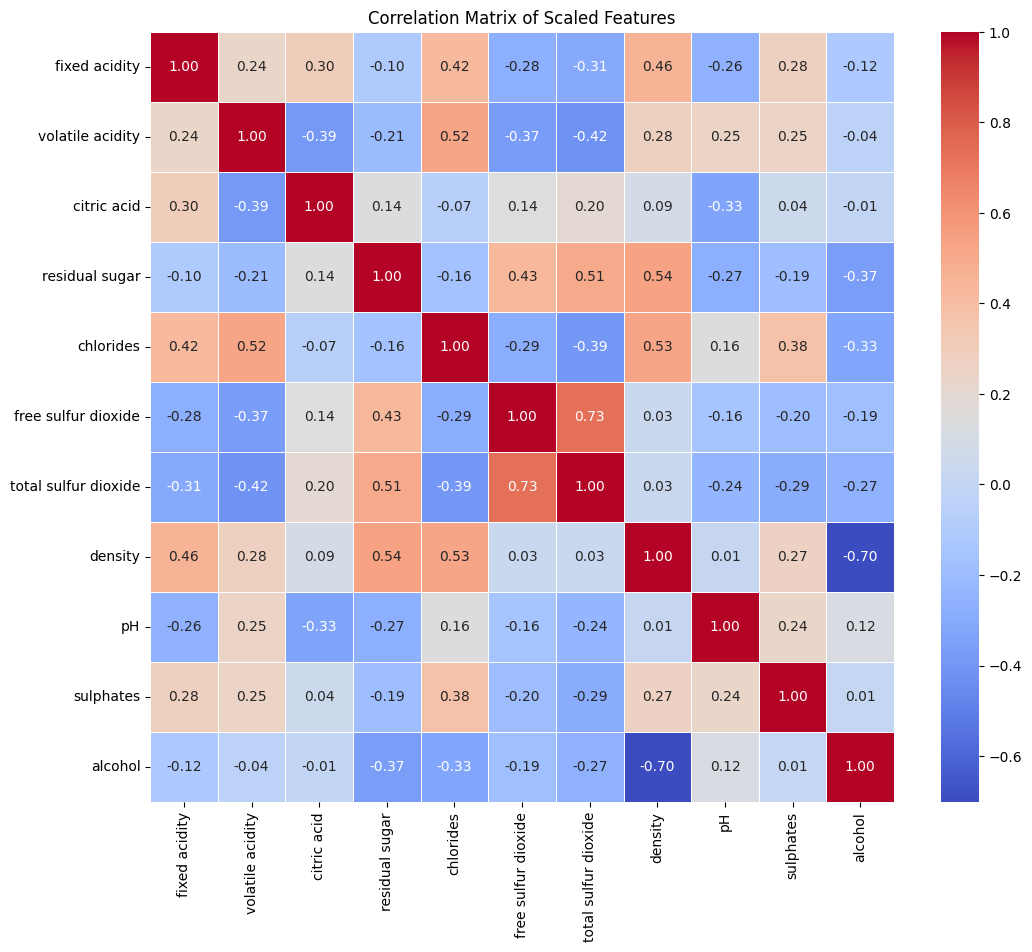


Identifying highly correlated features for potential reduction (absolute correlation > 0.8):

No features removed based on the correlation threshold (0.8).

Final number of features for dimensionality reduction: 11


In [ ]:
# --- Low Variance Features ---
print("\nVariance of each feature:")
feature_variances = X_scaled.var()
print(feature_variances)

# --- Correlated Features ---
# High correlation between features indicates redundancy. We can remove one of the correlated features.
print("\nCalculating correlation matrix...")
correlation_matrix = X_scaled.corr()

# Plotting the correlation heatmap for better visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Scaled Features')
plt.show()

# Identify highly correlated pairs 
print("\nIdentifying highly correlated features for potential reduction (absolute correlation > 0.8):")
correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8: # Threshold for high correlation
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            print(f"'{correlation_matrix.columns[j]}' and '{colname}' are highly correlated ({correlation_matrix.iloc[i, j]:.2f})")


if correlated_features:
    X_reduced_correlation = X_scaled.drop(columns=list(correlated_features))
    print(f"\nFeatures removed due to high correlation: {list(correlated_features)}")
    print(f"Shape of data after correlation reduction: {X_reduced_correlation.shape}")
else:
    X_reduced_correlation = X_scaled.copy()
    print("\nNo features removed based on the correlation threshold (0.8).")

final_features_for_dr = X_reduced_correlation
print(f"\nFinal number of features for dimensionality reduction: {final_features_for_dr.shape[1]}")


Applying PCA for dimensionality reduction...


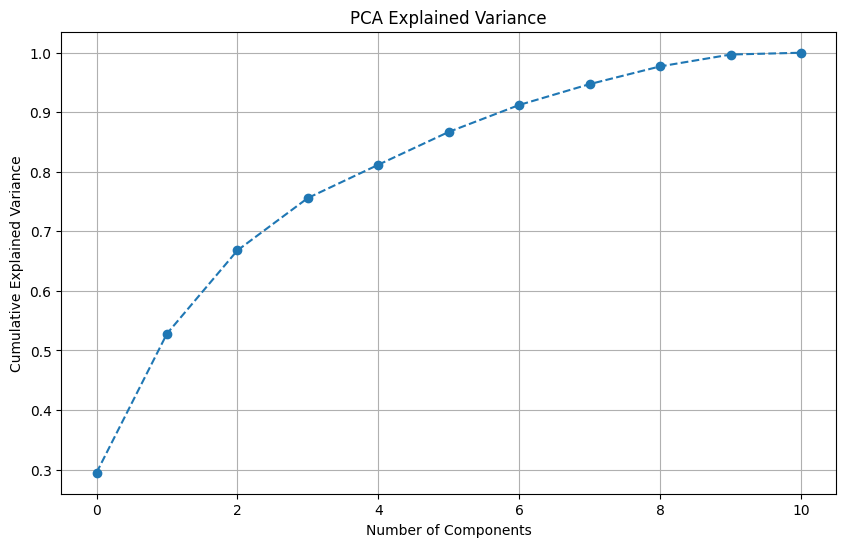


Shape of data after PCA with 2 components: (6497, 2)
Total variance explained by 2 PCA components: 0.53

First 5 rows of PCA reduced data:
       PC_1      PC_2  quality type
0 -3.594503  0.233995        5  red
1 -3.275456  0.988964        5  red
2 -3.548201  0.705089        5  red
3 -1.752827  1.708395        6  red
4 -3.594503  0.233995        5  red


In [ ]:
# --- Dimensionality Reduction: PCA ---

print("\nApplying PCA for dimensionality reduction...")

# Initialize PCA. We'll start by analyzing the explained variance to decide on the number of components.
pca = PCA()
pca.fit(final_features_for_dr)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

n_components_pca = 2 # For 2D visualization

pca_final = PCA(n_components=n_components_pca)
X_pca = pca_final.fit_transform(final_features_for_dr)

print(f"\nShape of data after PCA with {n_components_pca} components: {X_pca.shape}")
print(f"Total variance explained by {n_components_pca} PCA components: {pca_final.explained_variance_ratio_.sum():.2f}")

# Convert to DataFrame for easier handling and plotting
X_pca_df = pd.DataFrame(data=X_pca, columns=[f'PC_{i+1}' for i in range(n_components_pca)])
X_pca_df['quality'] = y.values
X_pca_df['type'] = wine_type.values

print("\nFirst 5 rows of PCA reduced data:")
print(X_pca_df.head())

In [ ]:
# --- Dimensionality Reduction: t-SNE ---
print("\nApplying t-SNE for dimensionality reduction...")

# Initialize t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(final_features_for_dr)

print(f"\nShape of data after t-SNE with 2 components: {X_tsne.shape}")

# Convert to DataFrame for easier handling and plotting
X_tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE_1', 'TSNE_2'])
X_tsne_df['quality'] = y.values
X_tsne_df['type'] = wine_type.values

print("\nFirst 5 rows of t-SNE reduced data:")
print(X_tsne_df.head())

# --- Optional: UMAP (Uniform Manifold Approximation and Projection) ---
# UMAP is another powerful technique, often faster than t-SNE and sometimes
# better at preserving both local and global structure.

# print("\nApplying UMAP for dimensionality reduction (optional, uncomment to run)...")
# umap_reducer = umap.UMAP(n_components=2, random_state=42)
# X_umap = umap_reducer.fit_transform(final_features_for_dr)

# print(f"\nShape of data after UMAP with 2 components: {X_umap.shape}")

# X_umap_df = pd.DataFrame(data=X_umap, columns=['UMAP_1', 'UMAP_2'])
# X_umap_df['quality'] = y.values
# X_umap_df['type'] = wine_type.values

# print("\nFirst 5 rows of UMAP reduced data:")
# print(X_umap_df.head())


Applying t-SNE for dimensionality reduction...

Shape of data after t-SNE with 2 components: (6497, 2)

First 5 rows of t-SNE reduced data:
      TSNE_1     TSNE_2  quality type
0 -79.556892 -16.320200        5  red
1 -83.950951   7.610193        5  red
2 -84.058563   7.754964        5  red
3 -65.655914  44.793148        6  red
4 -79.556862 -16.320232        5  red


In [ ]:
# --- Dimensionality Reduction: t-SNE ---
print("\nApplying t-SNE for dimensionality reduction...")

# Initialize t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(final_features_for_dr)

print(f"\nShape of data after t-SNE with 2 components: {X_tsne.shape}")

# Convert to DataFrame for easier handling and plotting
X_tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE_1', 'TSNE_2'])
X_tsne_df['quality'] = y.values
X_tsne_df['type'] = wine_type.values

print("\nFirst 5 rows of t-SNE reduced data:")
print(X_tsne_df.head())

# --- Optional: UMAP (Uniform Manifold Approximation and Projection) ---
# UMAP is another powerful technique, often faster than t-SNE and sometimes
# better at preserving both local and global structure.

# print("\nApplying UMAP for dimensionality reduction (optional, uncomment to run)...")
# umap_reducer = umap.UMAP(n_components=2, random_state=42)
# X_umap = umap_reducer.fit_transform(final_features_for_dr)

# print(f"\nShape of data after UMAP with 2 components: {X_umap.shape}")

# X_umap_df = pd.DataFrame(data=X_umap, columns=['UMAP_1', 'UMAP_2'])
# X_umap_df['quality'] = y.values
# X_umap_df['type'] = wine_type.values

# print("\nFirst 5 rows of UMAP reduced data:")
# print(X_umap_df.head())


Applying t-SNE for dimensionality reduction...

Shape of data after t-SNE with 2 components: (6497, 2)

First 5 rows of t-SNE reduced data:
      TSNE_1     TSNE_2  quality type
0 -79.556892 -16.320200        5  red
1 -83.950951   7.610193        5  red
2 -84.058563   7.754964        5  red
3 -65.655914  44.793148        6  red
4 -79.556862 -16.320232        5  red



Visualizing PCA reduced data...


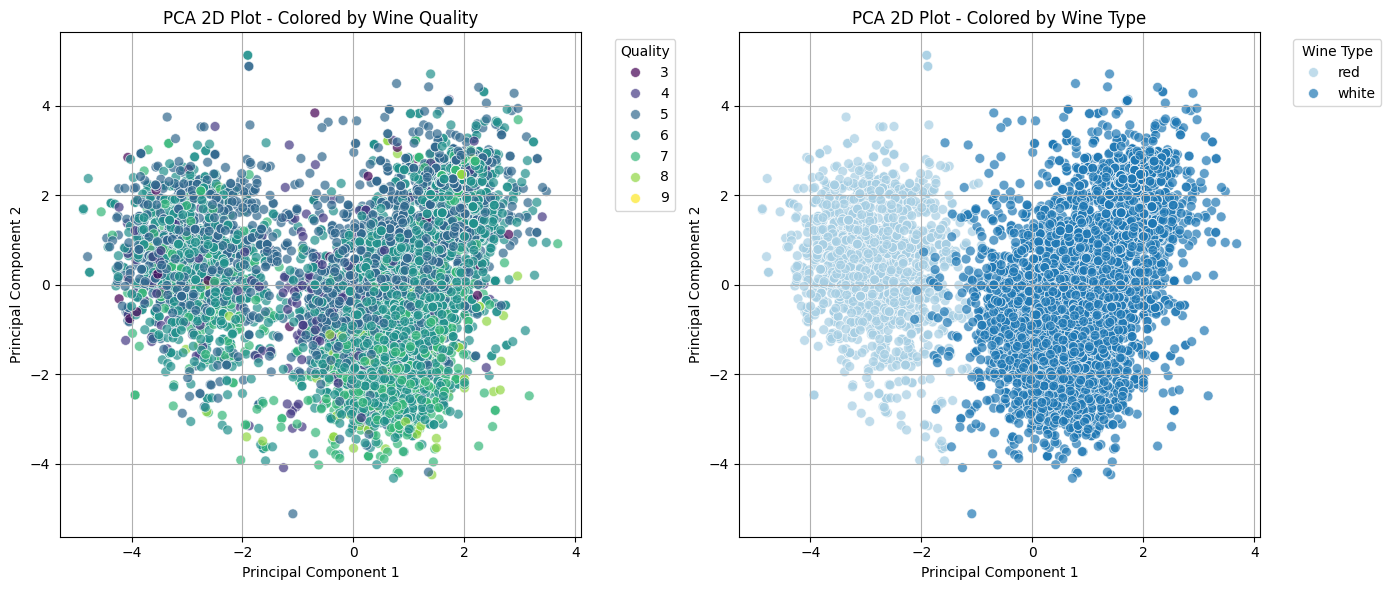


Visualizing t-SNE reduced data...


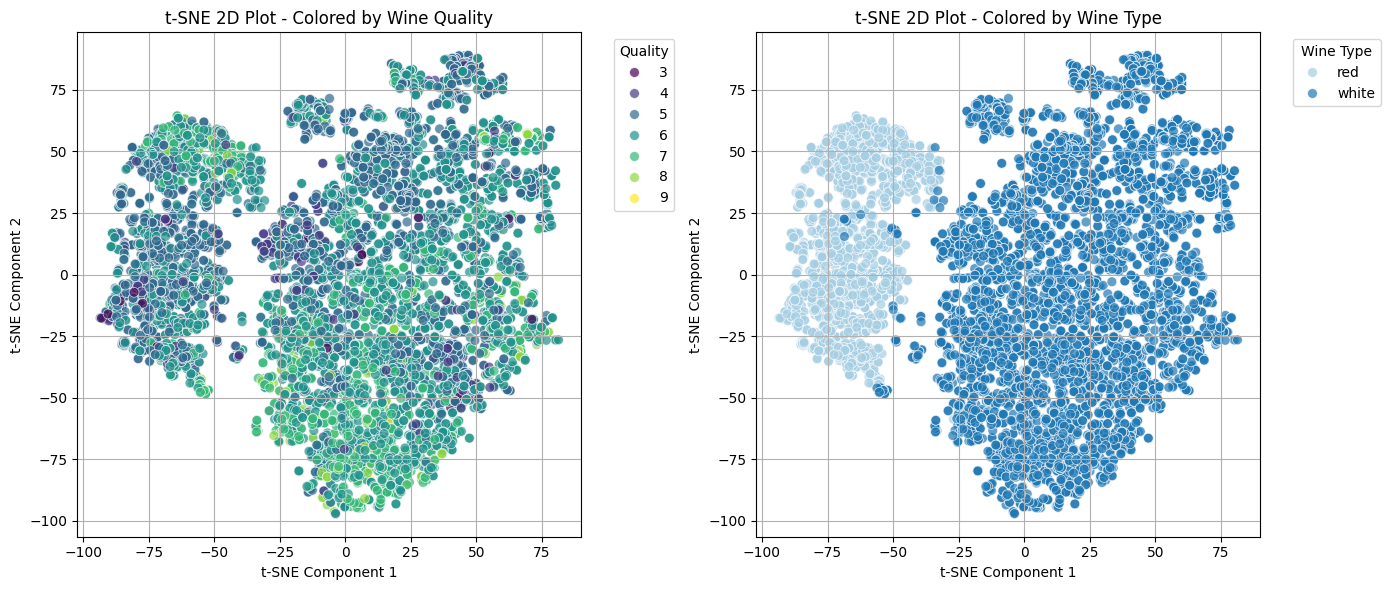

In [14]:
# --- Visualization of PCA Reduced Data ---

print("\nVisualizing PCA reduced data...")

plt.figure(figsize=(14, 6))

# Plot PCA by Quality
plt.subplot(1, 2, 1)
sns.scatterplot(x='PC_1', y='PC_2', hue='quality', palette='viridis', data=X_pca_df, s=50, alpha=0.7)
plt.title('PCA 2D Plot - Colored by Wine Quality')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Quality', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot PCA by Wine Type
plt.subplot(1, 2, 2)
sns.scatterplot(x='PC_1', y='PC_2', hue='type', palette='Paired', data=X_pca_df, s=50, alpha=0.7)
plt.title('PCA 2D Plot - Colored by Wine Type')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.legend(title='Wine Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# --- Visualization of t-SNE Reduced Data ---

print("\nVisualizing t-SNE reduced data...")

plt.figure(figsize=(14, 6))

# Plot t-SNE by Quality
plt.subplot(1, 2, 1)
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='quality', palette='viridis', data=X_tsne_df, s=50, alpha=0.7)
plt.title('t-SNE 2D Plot - Colored by Wine Quality')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.legend(title='Quality', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot t-SNE by Wine Type
plt.subplot(1, 2, 2)
sns.scatterplot(x='TSNE_1', y='TSNE_2', hue='type', palette='Paired', data=X_tsne_df, s=50, alpha=0.7)
plt.title('t-SNE 2D Plot - Colored by Wine Type')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.legend(title='Wine Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# --- Optional: Visualization of UMAP Reduced Data (if you ran UMAP above) ---
# if 'X_umap_df' in locals():
#     print("\nVisualizing UMAP reduced data...")
#     plt.figure(figsize=(14, 6))
#     plt.subplot(1, 2, 1)
#     sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='quality', palette='viridis', data=X_umap_df, s=50, alpha=0.7)
#     plt.title('UMAP 2D Plot - Colored by Wine Quality')
#     plt.xlabel('UMAP Component 1')
#     plt.ylabel('UMAP Component 2')
#     plt.grid(True)
#     plt.legend(title='Quality', bbox_to_anchor=(1.05, 1), loc='upper left')

#     plt.subplot(1, 2, 2)
#     sns.scatterplot(x='UMAP_1', y='UMAP_2', hue='type', palette='Paired', data=X_umap_df, s=50, alpha=0.7)
#     plt.title('UMAP 2D Plot - Colored by Wine Type')
#     plt.xlabel('UMAP Component 1')
#     plt.ylabel('UMAP Component 2')
#     plt.grid(True)
#     plt.legend(title='Wine Type', bbox_to_anchor=(1.05, 1), loc='upper left')

#     plt.tight_layout()
#     plt.show()


Creating a simple line graph...


C:\Users\Emperor\AppData\Local\Temp\ipykernel_15340\3648298634.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='type', y='quality', data=avg_quality_by_type, marker='o', palette='coolwarm')


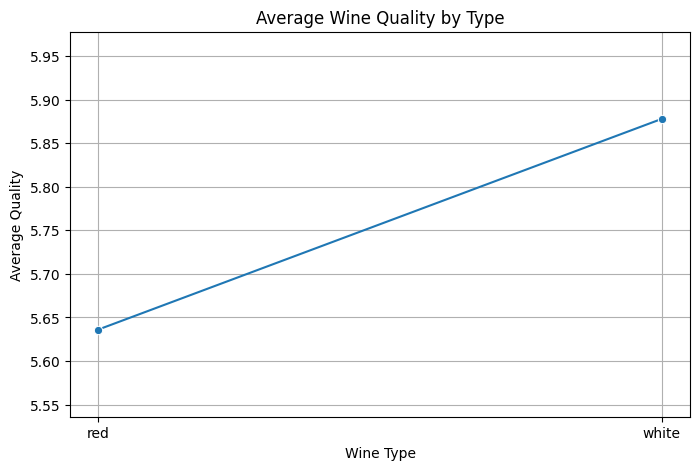

In [15]:
# --- Simple Line Graph ---

print("\nCreating a simple line graph...")

# Calculate the average quality for red and white wine
avg_quality_by_type = wine_data.groupby('type')['quality'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(x='type', y='quality', data=avg_quality_by_type, marker='o', palette='coolwarm')
plt.title('Average Wine Quality by Type')
plt.xlabel('Wine Type')
plt.ylabel('Average Quality')
plt.grid(True)
plt.ylim(min(avg_quality_by_type['quality']) - 0.1, max(avg_quality_by_type['quality']) + 0.1) # Adjust y-axis for better visibility
plt.show()